<a href="https://colab.research.google.com/github/Bolanle-kani/Data2bots/blob/master/Real_work.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! pip install rasterio
! pip install radiant_mlhub
! pip install eo-learn

     |████████████████████████████████| 19.3 MB 5.2 MB/s 
     |████████████████████████████████| 133 kB 7.5 MB/s 
     |████████████████████████████████| 61 kB 7.1 MB/s 
     |████████████████████████████████| 72 kB 1.0 MB/s 
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.25.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
     |████████████████████████████████| 47 kB 3.0 MB/s 
     |████████████████████████████████| 10

In [3]:
# Built-in modules
import sys
import os
import shutil
import datetime
import copy
import json
from pathlib import Path
from radiant_mlhub import Collection
from radiant_mlhub.client import _download as download_file
import tarfile
import glob
from typing import Tuple
import time


# Machine learning
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import joblib
from sklearn import preprocessing, metrics
from sklearn.metrics import log_loss

from sklearn.model_selection import StratifiedShuffleSplit

# Basics of Python data handling and visualization
import rasterio
import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Imports from eo-learn and sentinelhub-py
from eolearn.core import EOPatch, EOTask, FeatureType, LoadTask,MergeFeatureTask,MapFeatureTask, ZipFeatureTask, OverwritePermission
from eolearn.mask import AddValidDataMaskTask
from eolearn.features import NormalizedDifferenceIndexTask, LinearInterpolation, SimpleFilterTask, ValueFilloutTask
from eolearn.geometry import PointSamplingTask, ErosionTask

# Pytorch tensors
# Modelling - pytorch
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import torchvision.transforms as T
from torch.utils.data import Dataset
from torchvision import models, transforms
# Split the data into two groups:
from sklearn.model_selection import ShuffleSplit
# Create train_ds and val_ds
from torch.utils.data import Subset

/usr/local/lib/python3.7/dist-packages/yaml/constructor.py:126: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if not isinstance(key, collections.Hashable):


In [4]:
# DOWNLOAD_S1 = False # If you set this to true then the Sentinel-1 data will be downloaded

# # Select which imagery bands you'd like to download here
# DOWNLOAD_BANDS = {
#     'B01': True,
#     'B02': True,
#     'B03': True,
#     'B04': True,
#     'B05': True,
#     'B06': True,
#     'B07': True,
#     'B08': True,
#     'B8A': True,
#     'B09': True,
#     'B11': True,
#     'B12': True,
#     'CLM': True
# }

In [5]:
# FOLDER_BASE = 'ref_south_africa_crops_competition_v1'
# os.environ['MLHUB_API_KEY'] = 'ac55f7d60f86044b9d6229b038f1352e75026b57cec007a23cbc9f3a702716b5'

# def download_archive(archive_name):
#     if os.path.exists(archive_name.replace('.tar.gz', '')):
#         return
    
#     print(f'Downloading {archive_name} ...')
#     download_url = f'https://radiant-mlhub.s3.us-west-2.amazonaws.com/archives/{archive_name}'
#     download_file(download_url, '.')
#     print(f'Extracting {archive_name} ...')
#     with tarfile.open(archive_name) as tfile:
#         tfile.extractall()
#     os.remove(archive_name)

# for split in ['train','test']:
#     # Download the labels
#     labels_archive = f'{FOLDER_BASE}_{split}_labels.tar.gz'
#     download_archive(labels_archive)
    
#     # Download Sentinel-1 data
#     if DOWNLOAD_S1:
#         s1_archive = f'{FOLDER_BASE}_{split}_source_s1.tar.gz'
#         download_archive(s1_archive)
        

#     for band, download in DOWNLOAD_BANDS.items():
#         if not download:
#             continue
#         s2_archive = f'{FOLDER_BASE}_{split}_source_s2_{band}.tar.gz'
#         download_archive(s2_archive)
        
# def resolve_path(base, path):
#     return Path(os.path.join(base, path)).resolve()
        
# def load_df(collection_id):
#     split = collection_id.split('_')[-2]
#     collection = json.load(open(f'{collection_id}/collection.json', 'r'))
#     rows = []
#     item_links = []
#     for link in collection['links']:
#         if link['rel'] != 'item':
#             continue
#         item_links.append(link['href'])
        
#     for item_link in item_links:
#         item_path = f'{collection_id}/{item_link}'
#         current_path = os.path.dirname(item_path)
#         item = json.load(open(item_path, 'r'))
#         tile_id = item['id'].split('_')[-1]
#         for asset_key, asset in item['assets'].items():
#             rows.append([
#                 tile_id,
#                 None,
#                 None,
#                 asset_key,
#                 str(resolve_path(current_path, asset['href']))
#             ])
            
#         for link in item['links']:
#             if link['rel'] != 'source':
#                 continue
#             source_item_id = link['href'].split('/')[-2]
            
#             if source_item_id.find('_s1_') > 0 and not DOWNLOAD_S1:
#                 continue
#             elif source_item_id.find('_s1_') > 0:
#                 for band in ['VV', 'VH']:
#                     asset_path = Path(f'{FOLDER_BASE}_{split}_source_s1/{source_item_id}/{band}.tif').resolve()
#                     date = '-'.join(source_item_id.split('_')[10:13])
                    
#                     rows.append([
#                         tile_id,
#                         f'{date}T00:00:00Z',
#                         's1',
#                         band,
#                         asset_path
#                     ])
                
#             if source_item_id.find('_s2_') > 0:
#                 for band, download in DOWNLOAD_BANDS.items():
#                     if not download:
#                         continue
                    
#                     asset_path = Path(f'{FOLDER_BASE}_{split}_source_s2_{band}/{source_item_id}_{band}.tif').resolve()
#                     date = '-'.join(source_item_id.split('_')[10:13])
#                     rows.append([
#                         tile_id,
#                         f'{date}T00:00:00Z',
#                         's2',
#                         band,
#                         asset_path
#                     ])
            
#     return pd.DataFrame(rows, columns=['tile_id', 'datetime', 'satellite_platform', 'asset', 'file_path'])

# train_df = load_df(f'{FOLDER_BASE}_train_labels')
# test_df = load_df(f'{FOLDER_BASE}_test_labels')

In [6]:
def load_image(paths):
  img = list()
  for path in paths:
      band = rasterio.open(path)
      band_array = band.read(1)
      #band_array = np.expand_dims(band.read(1).flatten(), axis=1)
      img.append(band_array)
  return np.dstack(img)

def load_timeseries(band_paths: list):
  global idx
  tstack = list()
  for i in range(0, len(band_paths),13):
    band_path = band_paths[idx:idx+13]
    tstack.append(load_image(band_path))
    idx+=13
  return np.stack(tstack)

def load_label(labels_path):
  raster = rasterio.open(labels_path)
  return raster.read(1)

def load_field_id(fields_path):
  raster = rasterio.open(fields_path)
  return raster.read(1)

In [7]:
def get_tiles_path(train_df):
  bands = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07','B08', 'B09', 'B11', 'B12', 'B8A', 'CLM']
  tile_ids_train = train_df['tile_id'].unique()
  tile_paths = {}
  for tile_id in tile_ids_train:
    tile_df = train_df[train_df['tile_id']==tile_id]
    paths = [str(file_path) for file_path in tile_df['file_path']]

    bands_paths = [file_path for file_path in paths if any(f in file_path for f in bands) ]
    label_path = [file_path for file_path in paths if any(f in file_path for f in ['labels.tif']) ]
    filed_id_path = [file_path for file_path in paths if any(f in file_path for f in ['field_ids.tif']) ]
    tile_dates = [date for date in tile_df['datetime'] if date is not None ]

    tile_paths[tile_id] = []

    tile_paths[tile_id].append(bands_paths)
    tile_paths[tile_id].append(label_path)
    tile_paths[tile_id].append(filed_id_path)
    tile_paths[tile_id].append(tile_dates)
    
  return tile_paths

In [8]:
# Work flow of prepare the eopatch (count valid pixels, extract Indices, ...)

band_names = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07',
         'B08', 'B09', 'B11', 'B12', 'B8A', 'CLM']

# 1.0 count valid pixels
class AddValidCountTask(EOTask):
  def __init__(self, count_what, feature_name):
    self.what = count_what
    self.name = feature_name

  def execute(self, eopatch):
    eopatch[(FeatureType.MASK_TIMELESS, self.name)] = np.count_nonzero(eopatch.mask[self.what], axis=0)
    return eopatch

AddValidCount = AddValidCountTask('Valid_Data', 'Valid_Count')

# 2.0 CALCULATING NEW FEATURES (extract Indices)
## NDVI: (B08 - B04)/(B08 + B04)
## NDWI: (B03 - B08)/(B03 + B08)
## NDBI: (B11 - B08)/(B11 + B08)
ndvi = NormalizedDifferenceIndexTask((FeatureType.DATA, 'S2-BANDS-L2A'), (FeatureType.DATA, 'NDVI'),
                                     [band_names.index('B08'), band_names.index('B04')])
ndwi = NormalizedDifferenceIndexTask((FeatureType.DATA, 'S2-BANDS-L2A'), (FeatureType.DATA, 'NDWI'),
                                     [band_names.index('B03'), band_names.index('B08')])
ndbi = NormalizedDifferenceIndexTask((FeatureType.DATA, 'S2-BANDS-L2A'), (FeatureType.DATA, 'NDBI'),
                                     [band_names.index('B11'), band_names.index('B08')])



# 3.0 FEATURE CONCATENATION
concatenate = MergeFeatureTask({FeatureType.DATA: ['S2-BANDS-L2A', 'NDVI', 'NDWI', 'NDBI']},
                               (FeatureType.DATA, 'FEATURES'))


# 4.0 Remove frames with valid data less than 80% 
class ValdDataFractionPredicate:
     
    ## Predicate that defines if a frame from EOPatch's time-series is valid or not. Frame is valid if the
    ## valid data fraction is above the specified threshold.
    def __init__(self, threshold):
      self.threshold = threshold

    def __call__(self, array):
      #clouds = np.count_nonzero(eopatch.mask[self.what] == 1, axis=0)
      #array = np.logical_not(array.astype(bool))
      coverage = np.sum(array.astype(np.uint8)) / np.prod(array.shape)
      return coverage > self.threshold

## 4.1 Keep frames with > 80% valid data
valid_data_predicate = ValdDataFractionPredicate(0.80)
filter_task = SimpleFilterTask((FeatureType.MASK, 'Valid_Data'), valid_data_predicate)

# 6.0 EROSION
## erode each class of the reference map
erosion = ErosionTask(mask_feature=(FeatureType.MASK_TIMELESS,'CROP_ID','CROP_ERODED'), disk_radius=1)


## Fill missing values
fillout = ValueFilloutTask((FeatureType.DATA, 'FEATURES'), 'fb')


In [9]:
def save_data(data, field_id, dates, folder, label= None):
    """
    Creates an EOPatch and adds data:    
    """
    if label is None:
      # 5.0 LINEAR TEMPORAL INTERPOLATION
      ## linear interpolation of full time-series and date resampling
      resampled_range = ('2017-04-01', '2017-11-30', 20)
      linear_interp = LinearInterpolation(
          'FEATURES', # name of field to interpolate
          mask_feature=(FeatureType.MASK, 'Valid_Data'), # mask to be used in interpolation
          copy_features=[(FeatureType.MASK_TIMELESS, 'FIELD_ID')], # features to keep
          resample_range=resampled_range)
    else:
      # 5.0 LINEAR TEMPORAL INTERPOLATION
      ## linear interpolation of full time-series and date resampling
      resampled_range = ('2017-04-01', '2017-11-30', 20)
      linear_interp = LinearInterpolation(
          'FEATURES', # name of field to interpolate
          mask_feature=(FeatureType.MASK, 'Valid_Data'), # mask to be used in interpolation
          copy_features=[(FeatureType.MASK_TIMELESS, 'CROP_ID'),(FeatureType.MASK_TIMELESS, 'FIELD_ID')], # features to keep
          resample_range=resampled_range,)
      
    eopatch = EOPatch()
    
    # Add features to the eopatch
    eopatch.add_feature(FeatureType.DATA, 'S2-BANDS-L2A', data[..., :12])
    eopatch.add_feature(FeatureType.MASK_TIMELESS, 'FIELD_ID', field_id[...,np.newaxis])
    eopatch.timestamp = dates

    if label is not None:
      eopatch.add_feature(FeatureType.MASK_TIMELESS, 'CROP_ID', label[...,np.newaxis])
      

    # Valid data
    cloud_mask = data[..., -1][...,np.newaxis]
    cloud_mask = np.where(cloud_mask==255, 0, cloud_mask)
    valid_data =  np.logical_not(cloud_mask)
    eopatch.add_feature(FeatureType.MASK, 'Valid_Data', valid_data)
  

    # Extract new features
    eopatch = ndvi.execute(eopatch)
    eopatch = ndwi.execute(eopatch)
    eopatch = ndbi.execute(eopatch)
    eopatch = concatenate.execute(eopatch) 

    # Remove frames with less than 80% of valid data
    eopatch = filter_task.execute(eopatch)

    # Linear interpolation - resample time series
    eopatch = linear_interp.execute(eopatch)
    eopatch = fillout.execute(eopatch)

    
    fields = eopatch.mask_timeless['FIELD_ID']
    featuers = eopatch.data['FEATURES']
    
    if label is not None:
      crops = eopatch.mask_timeless['CROP_ID']

    for field in np.unique(fields):
      if field != 0:
        mask = fields == field
        masked_field = np.ma.masked_array(fields, ~mask)
        if label is not None:
          masked_crop = np.ma.masked_array(crops, ~mask)
        
        true_points = np.argwhere(masked_field)
        top_left = true_points.min(axis=0)
        bottom_right = true_points.max(axis=0)
        cropped_featuers = featuers[:,top_left[0]:bottom_right[0]+1,top_left[1]:bottom_right[1]+1]
        cropped_featuers = cropped_featuers.transpose([0,3,1,2]) 

        if label is not None:
          cropped_mask = masked_crop[top_left[0]:bottom_right[0]+1,top_left[1]:bottom_right[1]+1]
          crop_id = np.bincount(cropped_mask.data[np.nonzero(cropped_mask.data)]).argmax()
          cropped_mask = np.where(cropped_mask.data == crop_id, crop_id, 0)

          np_folder = f'{folder}/{crop_id-1}/{field}.npy'
          #np.savez(np_folder, features=cropped_featuers, labels=cropped_mask)
          
          np.save(np_folder, cropped_featuers,allow_pickle=True, fix_imports=True)
        
        else:
          np_folder = f'{folder}/{field}.npy'
          np.save(np_folder, cropped_featuers,allow_pickle=True, fix_imports=True)


In [10]:
## location of exported fields images
data_dir = ['./drive/MyDrive/Zindi/train', './drive/MyDrive/Zindi/test']

for directory in data_dir:
  if not os.path.isdir(directory):
      os.makedirs(directory)
      if directory == './drive/MyDrive/Zindi/train':
        for c in range(9):
          os.mkdir(f"{directory}/{c}")
      
def read_data(all_paths, tiles , data_type='train'):
  global idx
  l =[]
  for tile in tqdm.tqdm(tiles):
    idx = 0
    # Create numpy file
    folder = f'./drive/MyDrive/Zindi/{data_type}'

    tile_paths = all_paths[tile]

    # Extract time series
    all_bands_path = tile_paths[0]
    timeseries = load_timeseries(all_bands_path)
    # Extract fields IDs
    fields = load_field_id(tile_paths[2][0])
    dates= list(np.unique(tile_paths[3]))

    if data_type != 'test':
      # Extract the labels (crops IDs)
      labels = load_label(tile_paths[1][0])

    if data_type != 'test':
      eopatch = save_data(timeseries, fields, dates, folder, label= labels)
    else:
      eopatch = save_data(data, fields, folder, dates)


    del timeseries, labels, fields, dates
    
    ## No need for this anymore - because we have enough storage now :)
    #shutil.rmtree(tile_paths[2][0].replace('field_ids.tif',""))
    #for pand_path in all_bands_path:
    #   os.remove(pand_path)
  

##Modeling

In [11]:
# Define the CropsDataset class:
class CropsDataset(Dataset):
  def __init__(self, paths_df, transform=True, data='train'):
    self.paths_df = paths_df
    self.transform = transform
    self.data = data
      
  def __len__(self):
    return self.paths_df.shape[0]

  def pad_crop(self, features):
    """
     Padding and croping to size 64*64
    """
    train_arr = torch.zeros((13,15,64,64))
    t,c,h,w = features.shape
    if h <= 64 and w <= 64:
      train_arr[:,:,:h,:w] = features
    elif h<=64:
      features = features[:,:,:,:64]
      train_arr[:,:,:h,:w] = features
    elif w<=64:
      features = features[:,:,:64,:]
      train_arr[:,:,:h,:w] = features  
    else:
      train_arr = features[:,:,:64,:64]
      
    return train_arr

  def augment(self, img):
    p = np.random.random(4)
    ## Apply flipping
    if p[0] > 0.5:
      img = TF.hflip(img)
    if p[1] > 0.5:
      img = TF.vflip(img)
    ## Apply rotation
    if p[2] > 0.5:
      angle = np.random.randint(-30, 30)
      img = TF.rotate(img, angle)

    return img

  def __getitem__(self, index):
  
    img_path = self.paths_df['Path'][index]
    
    features = np.load(img_path, allow_pickle=True) # this if we save the numpy as np

    #features= np.load(img_path)['features'] # this if we save the numpy as npz, in case saved with the crop mask (for segmentation)

    field = self.paths_df['Field'][index]
   
    label= 0
    if self.data != 'test':
      label = self.paths_df['Crop'][index]
      label = torch.tensor(label, dtype=torch.long)

    features = torch.tensor(features, dtype=torch.float32)
    if self.transform:
      features = self.augment(features)
    
    #features = torch.tensor(features, dtype=torch.float32)

    return self.pad_crop(features), label , field

In [12]:
Preprocess = True
if Preprocess:
  paths = glob.glob('./drive/MyDrive/Zindi/train/*/*.npy')
  train_paths_df = pd.DataFrame(paths, columns =['Path'])
  f = lambda x: int(x["Path"].split("/")[-1][:-4])
  c = lambda x: int(x["Path"].split("/")[-2])
  train_paths_df["Field"] = train_paths_df.apply(f, axis=1)
  train_paths_df["Crop"] = train_paths_df.apply(c, axis=1)
  train_paths_df.to_csv('/content/drive/MyDrive/Zindi/train_paths_df.csv', index=False)

train_paths_df = pd.read_csv('/content/drive/MyDrive/Zindi/train_paths_df.csv')
train_paths_df.head()

,Path,Field,Crop
0,./drive/MyDrive/Zindi/train/0/16713.npy,16713,0
1,./drive/MyDrive/Zindi/train/0/1196.npy,1196,0
2,./drive/MyDrive/Zindi/train/0/5309.npy,5309,0
3,./drive/MyDrive/Zindi/train/0/34415.npy,34415,0
4,./drive/MyDrive/Zindi/train/0/36486.npy,36486,0


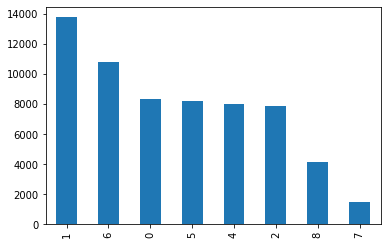

In [13]:
# Count the crops
train_paths_df['Crop'].value_counts().plot.bar()
plt.show()

In [14]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(train_paths_df, test_size=0.20, shuffle=True, random_state=1)

# Split test dataset into val/test sets - stratify shuffle
test_data, val_data =  train_test_split(test_data, test_size=0.50, shuffle=True, random_state=1,stratify=test_data['Crop'])

train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)
val_data = val_data.reset_index(drop=True)
print(train_data.shape)
print(test_data.shape)
print(val_data.shape)

(50244, 3)
(6280, 3)
(6281, 3)


In [15]:
# Check imbalance in train dataset
train_data.groupby('Crop').count()

,Path,Field
Crop,,
0,6637,6637
1,10956,10956
2,6352,6352
4,6473,6473
5,6608,6608
6,8707,8707
7,1199,1199
8,3312,3312


In [16]:
## create weights to use in the loss function
class_count = train_data.groupby('Crop').count().reset_index()
class_count['weights'] = class_count['Field'].max() / class_count['Field']
class_count

,Crop,Path,Field,weights
0,0,6637,6637,1.650746
1,1,10956,10956,1.000000
2,2,6352,6352,1.724811
3,4,6473,6473,1.692569
4,5,6608,6608,1.657990
5,6,8707,8707,1.258298
6,7,1199,1199,9.137615
7,8,3312,3312,3.307971


In [17]:
# Define data loaders
datasets = {'train': CropsDataset(train_data, transform=True, data='train'),
            'val': CropsDataset(val_data, transform=False, data='val'),
            'test': CropsDataset(test_data, transform=False, data='test')     
            }


# Define data loaders
dataloaders = {'train': torch.utils.data.DataLoader(datasets['train'], batch_size=16, shuffle=True, num_workers=4),
              'val': torch.utils.data.DataLoader(datasets['val'], batch_size=16, shuffle=True, num_workers=4),
               'test': torch.utils.data.DataLoader(datasets['test'], batch_size=16, shuffle= False, num_workers=4)}

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [19]:
for feature1, label1, field1 in datasets['train']:
  print(feature1.shape)
  print(label1.shape)
  break

torch.Size([13, 15, 64, 64])
torch.Size([])


In [34]:
  print(label1)


tensor(6)


In [18]:
for feature, label,field in dataloaders['train']:
  print(feature.shape)
  print(label.shape)
  break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([16, 13, 15, 64, 64])
torch.Size([16])


In [ ]:
X = 

In [ ]:
b = feature1.numpy()
b



In [ ]:
b = b.reshape()

In [30]:

df = pd.DataFrame(b)
df.head()

ValueError: ignored

In [31]:
# Define data loaders
datasets1 = {'train': CropsDataset(train_data, transform=True, data='train'),
            'val': CropsDataset(val_data, transform=False, data='val'),
            'test': CropsDataset(test_data, transform=False, data='test')     
            }


# # Define data loaders
# dataloaders = {'train': torch.utils.data.DataLoader(datasets['train'], batch_size=16, shuffle=True, num_workers=4),
#               'val': torch.utils.data.DataLoader(datasets['val'], batch_size=16, shuffle=True, num_workers=4),
#                'test': torch.utils.data.DataLoader(datasets['test'], batch_size=16, shuffle= False, num_workers=4)}

In [32]:
  print(feature2.shape)
  print(label2.shape)
  break

torch.Size([13, 15, 64, 64])
torch.Size([])


StratifiedKFold, Standard Scaler,  Stacked classifier, MLP classifier, voting classifier